# Q-Learning Algorithms and their Application to Optimal Trading Problems:
## The Q-learning implementation

The goal of the algorithm: take a mean reverting strategy once you are at the bounds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed
import xarray as xr

In [2]:
%precision 4
%config InlineBackend.figure_format = "retina"

## The Ornstein-Uhlenbeck process

$$
    S_{t+1} = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where
* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the *stardard* deviation of the process

In [3]:
# Going from (kappa, theta, sigma) -> (alpha, beta, gamma)
# does not seem to work properly (variance is way too low)
dt = 1 / 60
kappa, theta, sigma = 1e-5, 1, 2

alpha = theta * (1 - np.exp(-kappa * dt))
beta = np.exp(-kappa * dt)
gamma = np.sqrt(sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa))

$$
    X_{t_i + 1} = \alpha + \beta X_{t_i}
$$

In [4]:
alpha, beta, gamma

(1.6666665281217519e-07, 0.9999998333333472, 0.25819886822283034)

In [5]:
timesteps = 500
t = np.linspace(0, 2, timesteps)

alpha, beta = .08, 0.98
gamma = .2
e_t = randn(timesteps) * gamma

In [6]:
seed(314)
x0 = 1.5
X = np.zeros(timesteps)
for t in range(timesteps):
    if t == 0:
        X[t] = x0
    else:
        X[t] = alpha + beta * X[t-1] + e_t[t-1]
X = X

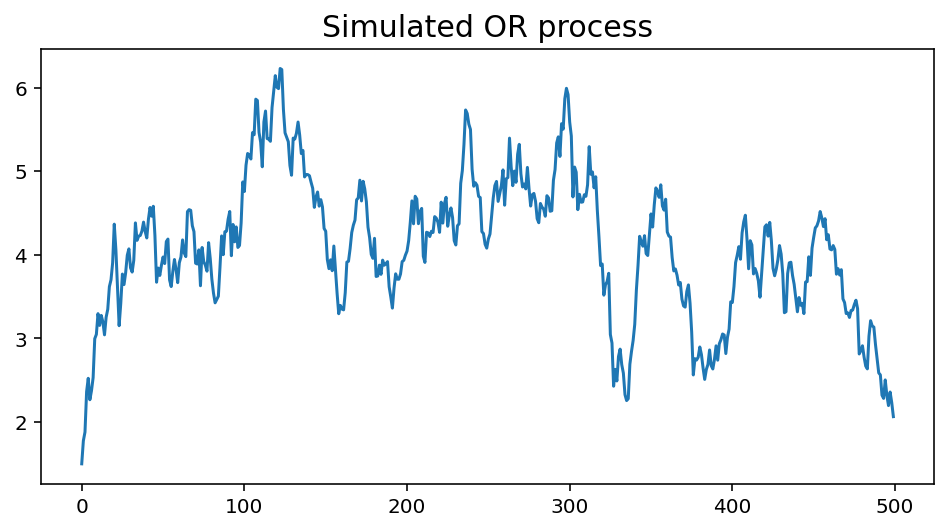

In [7]:
plt.figure(figsize=(8, 4))
plt.title("Simulated OR process", fontsize=15)
plt.plot(X);

We consider a three-tuple state that takes us to a single action

```
* T: terminal time (0, T)
* N: intermediate trading periods
* A: Number of shares traded at a single period
* Q: Current inventory
```

In [8]:
T, N, A, Q = 1, 1, 1, 1
Q = np.zeros((T, N, A, Q))

In [9]:
sigma = np.sqrt(2 * gamma ** 2 * np.log(beta) / (beta ** 2 - 1))
sigma

0.20202363756848574

In [10]:
n = 3.5
xmin, xmax = theta + np.array([-1, 1]) *  n * sigma / np.sqrt(2 * kappa)
xmin, xmax

(-157.10850533272006, 159.10850533272006)

In [11]:
# When we simulate our price path, we bin our observations
# into into intervals degined by the grid-points
M = 100
delta_x = (xmax - xmin) / M
bins = np.arange(M) * delta_x + xmin

## Implementation

In [12]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = randn(nsteps - 1)
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
    
    return time, x

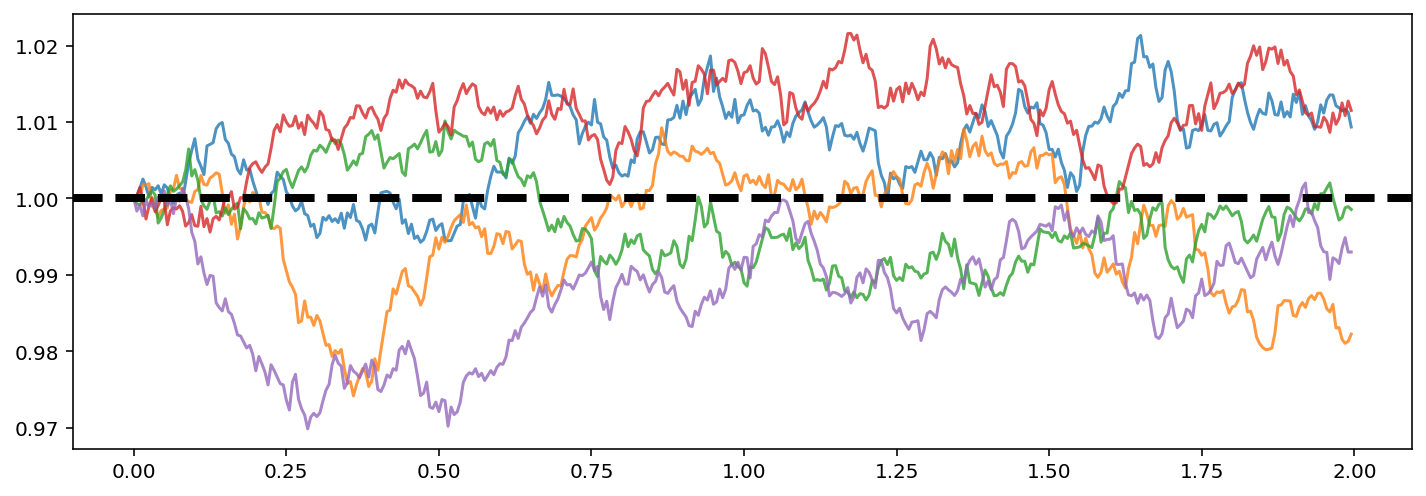

In [13]:
seed(314)
xbar = 1
plt.figure(figsize=(12, 4))
for _ in range(5):
    plt.plot(*simulate_ou_process(1, xbar, 1, 0.02, T=2, dt=0.005),
             alpha=0.8)
plt.axhline(y=xbar, linewidth=4, c="black", linestyle="--");

Reward at time $t_i$


$$
    R_i = q_{t_i} (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2
$$

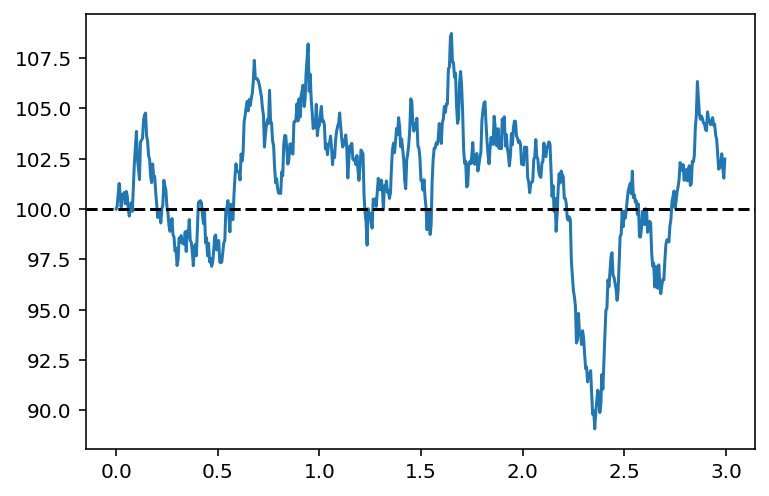

In [14]:
seed(314)
T, dt = 3, 0.005
x0, kappa, xbar, sigma = 100, 2, 100, 10
t, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
plt.plot(t, Xt)
plt.axhline(y=xbar, c="black", linestyle="--")

In [15]:
sell_min, buy_max = 5, 5
phi = 0.01
Qmin, Qmax = -10, 10
bucket_size = 0.1
xmin, xmax = 90, 110
prices = np.arange(xmin, xmax, 0.1)
inventory = np.arange(-50, 50)
actions = np.arange(-sell_min, buy_max)

In [16]:
prices = np.round(prices, 1)

In [17]:
dimensions = ["time", "price", "inventory", "action"]
Q = xr.DataArray(0., coords=[t, prices, inventory, actions], dims=dimensions)

Reward at time $t_i$


$$
    R_i = \mathbb{E}\left[(q_{t_i} + a_{t_i})  (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2\right]
$$

In [18]:
Xt[1] - Xt[0]

0.11744013998976754

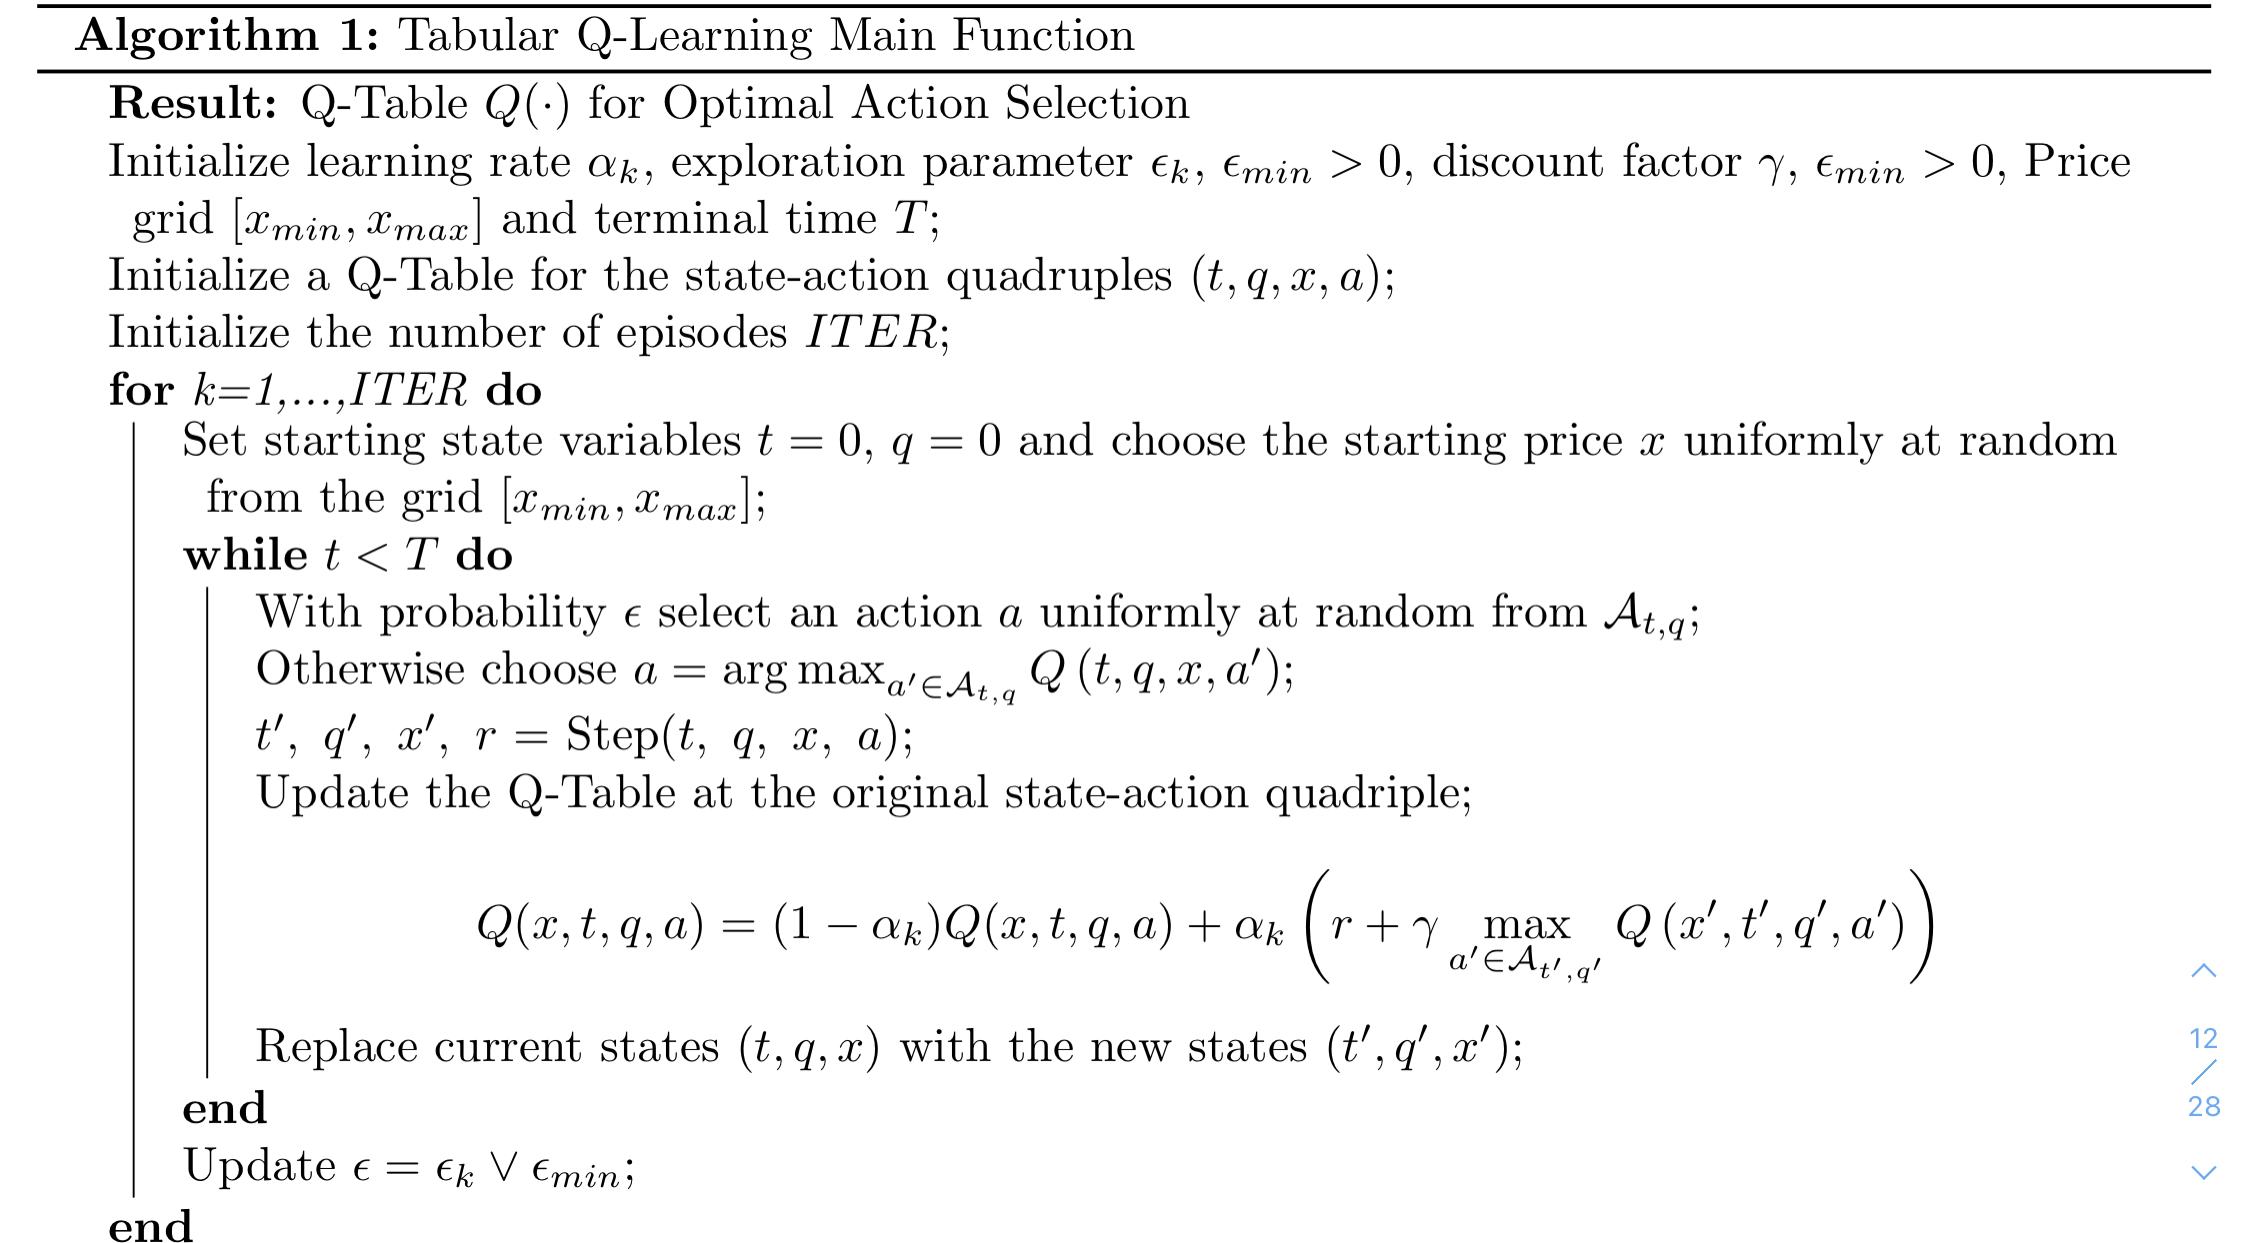

In [19]:
class QTrading:
    def __init__(self, kappa, sigma, xbar, phi, gamma=0.2, T=1, dt=0.01):
        self.kappa = kappa
        self.sigma = sigma
        self.xbar = xbar
        self.phi = phi
        self.gamma = gamma
        self.T = T
        self.dt = dt
        
    def next_price(self, price):
        discount_factor = np.exp(-self.kappa * self.dt)
        # is it self.sigma ** 2 or self.sigma?
        Z_2sigma = self.sigma / (2 * self.kappa) * (1 - discount_factor ** 2)
        Z = np.sqrt(Z_2sigma) * randn()
        price = price * discount_factor + self.xbar * (1 - discount_factor) + Z

        return price
        
    def step(self, time, inventory, price, action):
        q_new = inventory + action
        new_price = self.next_price(price)
        t_new = time + self.dt
        if t_new < self.T:
            r = q_new * (new_price-price) - self.phi * action ** 2
        else:
            r = q_new * (new_price-price) - self.phi * action ** 2 - c * q_new** 2
        
        new_price = np.round(new_price, 1)
        return r, t_new, q_new, new_price

In [20]:
qtrading = QTrading(kappa=1, sigma=4, xbar=100, phi=.01)

In [21]:
learning_rate = 0.01
discount_factor = 0.8

In [22]:
reward_new, t_new, inventory_new, price_new = qtrading.step(0, 0, 100, 10)
Q_new_max = Q.sel(price=price_new, time=0.01, inventory=inventory_new).max().values

target_entry = {
    "time": 0,
    "price": 100,
    "inventory": 0,
    "action": 0
}

Q_update = ((1 - learning_rate) * Q.sel(target_entry) +
         learning_rate * (reward_new + discount_factor * Q_new_max))

In [23]:
Q.loc[target_entry] = Q_update.values

Q.sel(target_entry)

<xarray.DataArray ()>
array(-0.0072)
Coordinates:
    time       float64 0.0
    price      float64 100.0
    inventory  int64 0
    action     int64 0